In [1]:
import pandas as pd
import os, time

%matplotlib inline

from IPython.display import display, HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [3]:
# Create timestamp to show when this summary was run
print 'Summary run: ' + time.strftime("%a, %d %b %Y %H:%M:%S")

Summary run: Wed, 31 Jan 2018 11:12:32


In [4]:
pd.options.display.float_format = '{:0,.0f}'.format

In [5]:
# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs/grouped'

In [6]:
tod_dict = {
    '5to6': 'AM',
    '6to7': 'AM',
    '7to8': 'AM',
    '8to9': 'AM',
    '9to10': 'Mid-Day',
    '10to14': 'Mid-Day',
    '14to15': 'Mid-Day',
    '15to16': 'PM',
    '16to17': 'PM',
    '17to18': 'PM',
    '18to20': 'Evening',
    '20to5': 'Night'
}

## Vehicle Miles Traveled (VMT)

In [7]:
df = pd.read_csv(os.path.join(relative_path,'net_summary.csv'))
df['time_period'] = df['tod'].apply(lambda row: tod_dict[row])

# VMT by Facility Type
df_dict = {}
for source in df.groupby('source').count().index.tolist():
    df_dict[source] = df[df['source'] == source]
    
df_fac = pd.DataFrame(df_dict[i][df_dict[i]['metric']=='vmt'].groupby('facility_type').sum()['value'] for i in df_dict.keys()).T
df_fac.columns=[i for i in df_dict.keys()]
df_fac.loc['Total'] = df_fac.sum()

# VMT by Time of Day        
df_tod = pd.DataFrame(df_dict[i][df_dict[i]['metric']=='vmt'].groupby('time_period').sum()['value'] for i in df_dict.keys()).T
df_tod.columns=[i for i in df_dict.keys()]
df_tod.loc['Total'] = df_tod.sum()
display(df_fac)
display(df_tod)

,sc_2040_av_test
facility_type,
arterial,"40,045,949"
connectors,"5,844,555"
highway,"47,100,971"
Total,"92,991,475"


,sc_2040_av_test
time_period,
AM,"22,189,390"
Evening,"11,176,666"
Mid-Day,"31,241,923"
Night,"6,609,038"
PM,"21,774,459"
Total,"92,991,475"


## Vehicle Hours Traveled (VHT)

In [8]:
df = pd.read_csv(os.path.join(relative_path,'net_summary.csv'))
df['time_period'] = df['tod'].apply(lambda row: tod_dict[row])

# VMT by Facility Type
df_dict = {}
for source in df.groupby('source').count().index.tolist():
    df_dict[source] = df[df['source'] == source]
    
df_fac = pd.DataFrame(df_dict[i][df_dict[i]['metric']=='vht'].groupby('facility_type').sum()['value'] for i in df_dict.keys()).T
df_fac.columns=[i for i in df_dict.keys()]
df_fac.loc['Total'] = df_fac.sum()

# VMT by Time of Day        
df_tod = pd.DataFrame(df_dict[i][df_dict[i]['metric']=='vht'].groupby('time_period').sum()['value'] for i in df_dict.keys()).T
df_tod.columns=[i for i in df_dict.keys()]
df_tod.loc['Total'] = df_tod.sum()
display(df_fac)
display(df_tod)

,sc_2040_av_test
facility_type,
arterial,"1,392,887"
connectors,"368,897"
highway,"1,149,402"
Total,"2,911,186"


,sc_2040_av_test
time_period,
AM,"722,034"
Evening,"358,841"
Mid-Day,"913,045"
Night,"167,353"
PM,"749,914"
Total,"2,911,186"


## Delay

In [9]:
df = pd.read_csv(os.path.join(relative_path,'net_summary.csv'))
df['time_period'] = df['tod'].apply(lambda row: tod_dict[row])

# VMT by Facility Type
df_dict = {}
for source in df.groupby('source').count().index.tolist():
    df_dict[source] = df[df['source'] == source]
    
df_fac = pd.DataFrame(df_dict[i][df_dict[i]['metric']=='delay'].groupby('facility_type').sum()['value'] for i in df_dict.keys()).T
df_fac.columns=[i for i in df_dict.keys()]
df_fac.loc['Total'] = df_fac.sum()
df_fac = df_fac.drop('connectors', axis=0)

# VMT by Time of Day        
df_tod = pd.DataFrame(df_dict[i][df_dict[i]['metric']=='delay'].groupby('time_period').sum()['value'] for i in df_dict.keys()).T
df_tod.columns=[i for i in df_dict.keys()]
df_tod.loc['Total'] = df_tod.sum()
display(df_fac)
display(df_tod)

,sc_2040_av_test
facility_type,
arterial,"295,099"
highway,"323,155"
Total,"618,254"


,sc_2040_av_test
time_period,
AM,"192,744"
Evening,"68,007"
Mid-Day,"140,808"
Night,"11,078"
PM,"205,617"
Total,"618,254"


## VMT per Person
From Daysim records

In [10]:
pd.options.display.float_format = '{:0,.2f}'.format

df = pd.read_csv(os.path.join(relative_path,'agg_measures.csv'))
# Save results by source as seperate df
df_dict = {}
for source in df.groupby('source').count().index.tolist():
    df_dict[source] = df[df['source'] == source]
    
_df = df[df['description'] == 'VMT per Person'][['source','value']]
#_df.index =['','']    # hide index
display(_df)

,source,value
0,sc_2040_av_test,0.09
2,survey,17.44


## Trips per Person

In [11]:
_df = df[df['description'] == 'Average Trips per Person'][['source','value']].reset_index(drop=True)
_df.index = ["" for i in xrange(len(_df))]    # hide index
display(_df)

,source,value
,sc_2040_av_test,3.88
,survey,4.54


## Average Trip Length

In [12]:
df = pd.read_csv(os.path.join(relative_path,'trips.csv'))
# Save results by source as seperate df
df_dict = {}
for source in df.groupby('source').count().index.tolist():
    df_dict[source] = df[df['source'] == source]

In [13]:
dfplot = pd.DataFrame([(df_dict[i]['travdist']*df_dict[i]['trexpfac']).sum()/df_dict[i]['trexpfac'].sum() for i in df_dict.keys()])
dfplot.columns = ['value']
dfplot['source'] = [i for i in df_dict.keys()]
dfplot.index = ["" for i in xrange(len(dfplot))]    # hide index
display(dfplot[['source','value']])

,source,value
,sc_2040_av_test,6.21
,survey,5.87


## Trip Mode Share

,sc_2040_av_test,survey
Bike,1.8%,1.4%
HOV2,22.0%,22.2%
HOV3+,14.5%,16.0%
SOV,36.1%,40.6%
School Bus,2.0%,2.2%
Transit,3.9%,4.4%
Walk,19.5%,12.7%


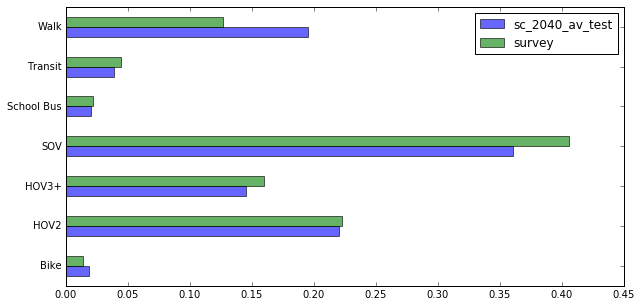

In [14]:
pd.options.display.float_format = '{:,.1%}'.format
dfplot = pd.DataFrame([df_dict[i].groupby('mode').sum()['trexpfac']/df_dict[i].sum()['trexpfac'] for i in df_dict.keys()]).T
dfplot = dfplot.drop('Other', axis=0)
dfplot.columns = df_dict.keys()
dfplot.plot(kind='barh', alpha=0.6, figsize=(10,5))
display(dfplot)